In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题
import random
import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models #主题挖掘，提取关键信息

#pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import graphviz

H:\ANAC\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 一、导入数据

In [2]:
raw_data= pd.read_excel(r"C:\Users\yanghong\Desktop\TD\C\附件1\酒店评论.xlsx")
raw_data.head()

,酒店名称,评论日期,评论内容,入住房型
0,H01,2020-01-01,酒店很适合家庭出行,标准客房
1,H01,2020-01-01,升级了房间 延迟退房 很赞,标准客房
2,H01,2020-01-01,这几年，每年都会来广州，每次都会住**酒店。因为位置好，酒店的性价比也不错，这次给免费升级了...,标准客房
3,H01,2020-01-01,酒店很好不错,标准客房
4,H01,2020-01-01,超五星好评,高级客房


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25225 entries, 0 to 25224
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   酒店名称    25225 non-null  object
 1   评论日期    25225 non-null  object
 2   评论内容    25225 non-null  object
 3   入住房型    25225 non-null  object
dtypes: object(4)
memory usage: 788.4+ KB


In [5]:
raw_data.columns

Index(['酒店名称', '评论日期', '评论内容', '入住房型'], dtype='object')

In [6]:
#取值分布
for cate in ['酒店名称','评论日期','评论内容','入住房型']:
    raw_data[cate].value_counts()

H01    1129
H02     964
H03     932
H04     914
H05     808
H06     714
H07     711
H08     698
H09     694
H10     634
H11     567
H12     563
H13     561
H14     554
H15     551
H16     543
H17     537
H18     532
H19     515
H20     513
H21     499
H22     494
H23     489
H24     485
H25     469
H26     450
H27     449
H28     423
H30     412
H29     412
H31     408
H32     397
H33     380
H34     378
H35     375
H36     371
H37     367
H38     365
H39     361
H40     361
H41     358
H42     354
H43     350
H44     334
H45     321
H46     317
H47     311
H48     305
H49     298
H50     298
Name: 酒店名称, dtype: int64

2020-08-23    269
2020-07-26    264
2020-08-09    260
2020-08-10    259
2020-08-16    247
             ... 
2020-02-18     17
2020-02-29     16
2020-02-19     14
2020-03-02     12
2020-02-24      9
Name: 评论日期, Length: 240, dtype: int64

好好好好好                             69
服务态度很好                            42
服务非常好                             41
服务态度好                             40
非常不错的酒店                           25
                                  ..
早餐很丰富，卫生和服务都很好                     1
除了餐饮不太方便，其他的还是蛮不错的                 1
酒店服务非常满意大堂林先生服务热情设施完善              1
服务很好，位置优越欢乐谷、世界之窗、民俗村很近，交通也方便！     1
服务态度不错很好的酒店                        1
Name: 评论内容, Length: 23167, dtype: int64

高级大床房        2797
标准大床房        1137
高级双床房        1096
豪华大床房         859
高级客房          710
             ... 
希岸女神套房          1
典雅豪华房           1
尊荣大床套房          1
大嘴猴亲子主题套房       1
全景套房            1
Name: 入住房型, Length: 443, dtype: int64

In [7]:
data=raw_data
data['评价']=0
datas=data['评价']
datas

0        0
1        0
2        0
3        0
4        0
        ..
25220    0
25221    0
25222    0
25223    0
25224    0
Name: 评价, Length: 25225, dtype: int64

In [11]:
for i in range(0,25225):
    abc=[]
    abc=datas[i]
    percent=87

    prob = random.randrange(0,100)
    if prob < percent:
        abc=1
    else:
        abc=0
    datas[i]=abc
print(datas)

<ipython-input-11-b968c9933302>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas[i]=abc


0        1
1        1
2        1
3        1
4        1
        ..
25220    1
25221    1
25222    1
25223    1
25224    1
Name: 评价, Length: 25225, dtype: int64


In [12]:
str(datas)

'0        1\n1        1\n2        1\n3        1\n4        1\n        ..\n25220    1\n25221    1\n25222    1\n25223    1\n25224    1\nName: 评价, Length: 25225, dtype: int64'

In [13]:
datass=datas.reset_index(level=False, drop=False, name='评价', inplace=False)
datass

,index,评价
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25220,25220,1
25221,25221,1
25222,25222,1
25223,25223,1


In [14]:
jqs=datass['评价']

In [15]:
data['评价']=jqs
data

,酒店名称,评论日期,评论内容,入住房型,评价
0,H01,2020-01-01,酒店很适合家庭出行,标准客房,1
1,H01,2020-01-01,升级了房间 延迟退房 很赞,标准客房,1
2,H01,2020-01-01,这几年，每年都会来广州，每次都会住**酒店。因为位置好，酒店的性价比也不错，这次给免费升级了...,标准客房,1
3,H01,2020-01-01,酒店很好不错,标准客房,1
4,H01,2020-01-01,超五星好评,高级客房,1
...,...,...,...,...,...
25220,H50,2020-08-24,酒店是老字号宾馆，虽然有装修过但设施比较陈旧房间空调比较小，卫生间里的墙壁有剥落现象，浴室的...,高级双床房,1
25221,H50,2020-08-24,本人觉得还好，价格偏高，没有很高档，服务是很好，设施偏老，也不会很大，喜欢楼下的早茶。,高级大床房,1
25222,H50,2020-08-24,隔音极差，睡眠让人崩溃。,高级大床房,1
25223,H50,2020-08-25,酒店位置很好，停车场比较小。,高级双床房,1


In [16]:
raw_data=data
raw_data

,酒店名称,评论日期,评论内容,入住房型,评价
0,H01,2020-01-01,酒店很适合家庭出行,标准客房,1
1,H01,2020-01-01,升级了房间 延迟退房 很赞,标准客房,1
2,H01,2020-01-01,这几年，每年都会来广州，每次都会住**酒店。因为位置好，酒店的性价比也不错，这次给免费升级了...,标准客房,1
3,H01,2020-01-01,酒店很好不错,标准客房,1
4,H01,2020-01-01,超五星好评,高级客房,1
...,...,...,...,...,...
25220,H50,2020-08-24,酒店是老字号宾馆，虽然有装修过但设施比较陈旧房间空调比较小，卫生间里的墙壁有剥落现象，浴室的...,高级双床房,1
25221,H50,2020-08-24,本人觉得还好，价格偏高，没有很高档，服务是很好，设施偏老，也不会很大，喜欢楼下的早茶。,高级大床房,1
25222,H50,2020-08-24,隔音极差，睡眠让人崩溃。,高级大床房,1
25223,H50,2020-08-25,酒店位置很好，停车场比较小。,高级双床房,1


## 二、数据预处理

### （一）去重

删除系统自动为客户做出的评论。

In [17]:
reviews=raw_data.copy()
reviews=reviews[['评论内容','评价']]
print('去重之前：',reviews.shape[0])
reviews=reviews.drop_duplicates()
print('去重之后：',reviews.shape[0])

去重之前： 25225
去重之后： 23420


### （二）数据清洗

In [18]:
# 清洗之前
content=reviews['评论内容']
for i in range(5,10):
    print(content[i])
    print('-----------')

酒店干净卫生，服务很好！
-----------
酒店位置??，属于传统的标准五星酒店，唯一遗憾的就是浴室只有浴缸，没有淋浴间。
-----------
酒店设施稍微有点旧，但地理位置确实优越
-----------
很不错 位置好 出行方便
-----------
地理位置很好 房间干净整洁
-----------


In [19]:
#清洗之后，将数字、字母等字样都删除
info=re.compile('[0-9a-zA-Z]|景区|')
content=content.apply(lambda x: info.sub('',x))  #替换所有匹配项

for i in range(5,10):
    print(content[i])
    print('-----------')

酒店干净卫生，服务很好！
-----------
酒店位置??，属于传统的标准五星酒店，唯一遗憾的就是浴室只有浴缸，没有淋浴间。
-----------
酒店设施稍微有点旧，但地理位置确实优越
-----------
很不错 位置好 出行方便
-----------
地理位置很好 房间干净整洁
-----------


### （三）分词、词性标注、去除停用词、词云图

(1)分词

In [20]:
#分词，由元组组成的list
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  

seg_content.shape
len(seg_content)
print(seg_content[5])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yanghong\AppData\Local\Temp\jieba.cache
Loading model cost 0.840 seconds.
Prefix dict has been built successfully.


(23420,)

23420

[('酒店', 'n'), ('干净', 'a'), ('卫生', 'an'), ('，', 'x'), ('服务', 'vn'), ('很', 'd'), ('好', 'a'), ('！', 'x')]


In [21]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

23420

0     5
1     9
2    35
3     4
4     3
5     8
Name: 评论内容, dtype: int64

In [22]:
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))] #[x+1]*y,表示复制y份，由list组成的list
index_content_long=sum(n_content,[]) #表示去掉[]，拉平,返回list
len(index_content_long)

538918

In [23]:
sum([[2,2],[3,3,3]],[])

[2, 2, 3, 3, 3]

In [24]:
#分词及词性，去掉[]，拉平
seg_content.head()

seg_content_long=sum(seg_content,[])

seg_content_long

type(seg_content_long)
len(seg_content_long)

0        [(酒店, n), (很, zg), (适合, v), (家庭, n), (出行, v)]
1    [(升级, vn), (了, ul), (房间, n), ( , x), (延迟, v), ...
2    [(这, r), (几年, m), (，, x), (每年, r), (都, d), (会,...
3                   [(酒店, n), (很, d), (好, a), (不错, a)]
4                          [(超, v), (五星, nz), (好评, v)]
Name: 评论内容, dtype: object

[('酒店', 'n'),
 ('很', 'zg'),
 ('适合', 'v'),
 ('家庭', 'n'),
 ('出行', 'v'),
 ('升级', 'vn'),
 ('了', 'ul'),
 ('房间', 'n'),
 (' ', 'x'),
 ('延迟', 'v'),
 ('退房', 'v'),
 (' ', 'x'),
 ('很', 'd'),
 ('赞', 'v'),
 ('这', 'r'),
 ('几年', 'm'),
 ('，', 'x'),
 ('每年', 'r'),
 ('都', 'd'),
 ('会', 'v'),
 ('来', 'v'),
 ('广州', 'ns'),
 ('，', 'x'),
 ('每次', 'r'),
 ('都', 'd'),
 ('会', 'v'),
 ('住', 'v'),
 ('*', 'x'),
 ('*', 'x'),
 ('酒店', 'n'),
 ('。', 'x'),
 ('因为', 'c'),
 ('位置', 'v'),
 ('好', 'a'),
 ('，', 'x'),
 ('酒店', 'n'),
 ('的', 'uj'),
 ('性价比', 'n'),
 ('也', 'd'),
 ('不错', 'a'),
 ('，', 'x'),
 ('这次', 'r'),
 ('给', 'p'),
 ('免费', 'vn'),
 ('升级', 'vn'),
 ('了', 'ul'),
 ('大', 'm'),
 ('房间', 'n'),
 ('。', 'x'),
 ('酒店', 'n'),
 ('很', 'd'),
 ('好', 'a'),
 ('不错', 'a'),
 ('超', 'v'),
 ('五星', 'nz'),
 ('好评', 'v'),
 ('酒店', 'n'),
 ('干净', 'a'),
 ('卫生', 'an'),
 ('，', 'x'),
 ('服务', 'vn'),
 ('很', 'd'),
 ('好', 'a'),
 ('！', 'x'),
 ('酒店', 'n'),
 ('位置', 'v'),
 ('?', 'x'),
 ('?', 'x'),
 ('，', 'x'),
 ('属于', 'v'),
 ('传统', 'n'),
 ('的', 'uj'),
 ('标准', 'n'),
 ('

list

538918

In [25]:
seg_content_long[0]

('酒店', 'n')

In [26]:
#得到加长版的分词、词性
word_long=[x[0] for x in seg_content_long]
nature_long=[x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

538918

538918

In [27]:
#拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['评价']),list(n_word))] #[x+1]*y,表示复制y份
content_type_long=sum(n_content_type,[]) #表示去掉[]，拉平

len(content_type_long)

538918

In [28]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})
review_long.shape
review_long.head()

(538918, 4)

,index_content,word,nature,content_type
0,1,酒店,n,1
1,1,很,zg,1
2,1,适合,v,1
3,1,家庭,n,1
4,1,出行,v,1


（2）去除标点符号、去除停用词

In [29]:
review_long['nature'].unique()

array(['n', 'zg', 'v', 'vn', 'ul', 'x', 'd', 'r', 'm', 'ns', 'c', 'a',
       'uj', 'p', 'nz', 'an', 'b', 'ad', 'q', 'l', 'f', 't', 'i', 's',
       'nr', 'yg', 'ng', 'y', 'df', 'nrt', 'u', 'uz', 'tg', 'ug', 'uv',
       'o', 'nt', 'z', 'e', 'ud', 'j', 'nrfg', 'vg', 'k', 'rr', 'mq', 'h',
       'g', 'ag', 'vq', 'vd', 'mg', 'vi', 'dg', 'rz'], dtype=object)

In [30]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x'] #x表示标点符合
review_long_clean.shape

(435378, 4)

In [31]:
#导入停用词
stop_path=open(r"C:\Users\yanghong\Desktop\TD\正面情感词语（中文）等\stoplist.txt",encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[0:5]

5749

['\ufeff酒店\n', '景区 \n', '说\n', '人\n', '元\n']

In [32]:
#停用词，预处理
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:5]

['\ufeff酒店', '景区 ', '说', '人', '元']

In [33]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

17447

(250102, 4)

(3)在原df中，再增加一列，该分词在本条评论的位置

In [34]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[]) #表示去掉[]，拉平

len(index_word_long)

index_content
1         4
2         5
3        12
4         2
5         3
         ..
25221    22
25222    12
25223     4
25224     3
25225     5
Name: word, Length: 22964, dtype: int64

250102

In [35]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
0,1,酒店,n,1,1
2,1,适合,v,1,2
3,1,家庭,n,1,3
4,1,出行,v,1,4
5,2,升级,vn,1,1


In [36]:
review_long_clean.to_csv('2_review_long_clean.csv')

(4)提取名词

In [37]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(132378, 5)

,index_content,word,nature,content_type,index_word
0,1,酒店,n,1,1
3,1,家庭,n,1,3
5,2,升级,vn,1,1
7,2,房间,n,1,2
21,3,广州,ns,1,2


In [39]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('2_n_review_long_clean.csv')

n       101047
vn       12937
nr        8859
ns        4670
nz        2102
an        1765
ng         585
nrt        250
nt         134
nrfg        29
Name: nature, dtype: int64

（5）词云图

<Figure size 1440x720 with 0 Axes>

(-0.5, 655.5, 536.5, -0.5)

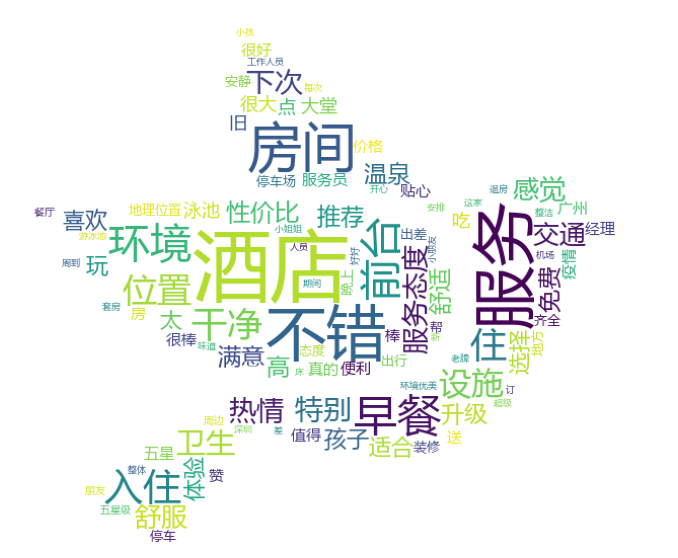

In [40]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white',mask=background_image) #width=1600,height=1200, mode='RGBA'
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1440x720 with 0 Axes>

(-0.5, 655.5, 536.5, -0.5)

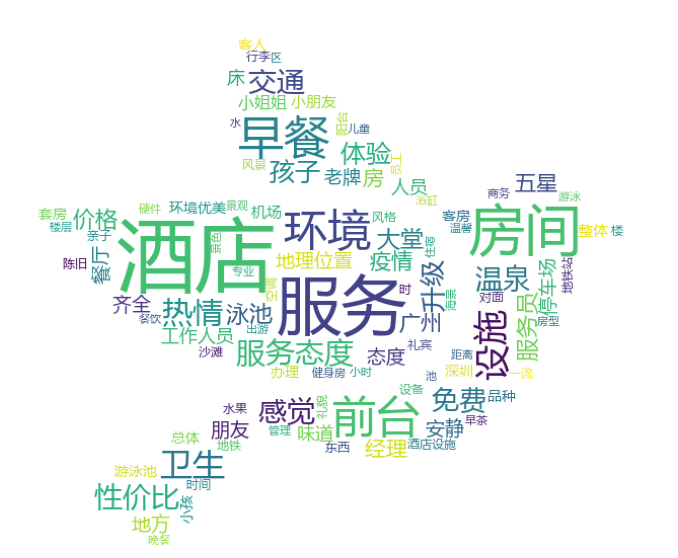

In [41]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 三、模型构建

In [42]:
review_long_clean

,index_content,word,nature,content_type,index_word
0,1,酒店,n,1,1
2,1,适合,v,1,2
3,1,家庭,n,1,3
4,1,出行,v,1,4
5,2,升级,vn,1,1
...,...,...,...,...,...
538907,25225,位置,v,1,1
538908,25225,好找,v,1,2
538910,25225,停车,v,1,3
538913,25225,酒店,n,1,4


### （一）基于决策树的情感分类

In [43]:
#第一步：构造特征空间和标签

Y=[]
for ind in review_long_clean.index_content.unique():
    y=[ word for word in review_long_clean.content_type[review_long_clean.index_content==ind].unique() ]
    Y.append(y)
len(Y)

X=[]
for ind in review_long_clean.index_content.unique():
    term=[ word for word in review_long_clean.word[review_long_clean.index_content==ind].values ]
    X.append(' '.join(term))
len(X)

X
Y

22964

22964

['酒店 适合 家庭 出行',
 '升级 房间 延迟 退房 赞',
 '几年 广州 每次 住 酒店 位置 酒店 性价比 不错 免费 升级 房间',
 '酒店 不错',
 '超 五星 好评',
 '酒店 干净 卫生 服务',
 '酒店 位置 传统 标准 五星 酒店 唯一 遗憾 浴室 浴缸 淋浴间',
 '酒店设施 稍微 旧 地理位置 确实 优越',
 '不错 位置 出行',
 '地理位置 房间 干净 整洁',
 '酒店 地理位置 地铁口 米 服务态度 棒 酒店 管理 不断进步 中 下次 入住 点 赞',
 '酒店 不错 选择',
 '距离 广州东站 接送 客人 价格合理 接受 早餐 不错 吃 好吃 品种齐全 适合 老幼 妇孺 自行 选择 食用',
 '性价比 高 早餐 品种 面包 种类 地铁',
 '广州东站 地铁站 吃饭 性价比 不错 推荐 入住 广州东站 地铁站 吃饭 性价比 不错 推荐 入住',
 '房间 服务 前台',
 '住 性价比 高',
 '酒店 广州东站 旁边',
 '卫生',
 '地点 佳 服务',
 '酒店 不错 服务',
 '早茶 不错',
 '酒店 性价比 高 不错 服务',
 '出差 火车站 对面 酒店 服务',
 '酒店 服务 挺不错 环境',
 '酒店 不错 干净',
 '朝食 美味 地下 安心 宿泊思 広 州 張 時 宿 頂',
 '交通 位置 便利 购物 吃',
 '不错 酒店 住 几天 性价比 高 推荐',
 '大堂 格调 温馨 电梯 楼层 设计 服务到位',
 '早餐 不错 交通 便利',
 '早餐 不错 出行',
 '不错 地理位置',
 '服务 环境 不错',
 '满意',
 '位置 步行 几分钟 广州东站 早餐 不错 房间 设施 不错 安静 书桌 适合 工作 服务员 热情 房间 清理 很好',
 '不错 酒店 性价比 高',
 '每次 广州 入住 酒店 设施 旧 酒店 位置 市中心 周边 热闹 房间 简洁 干净 住 习惯 吸引 早餐 精致 终于 打卡 桑拿房 不错 体验',
 '整体 感觉 不错',
 '好评 地理位置',
 '配不上 五星级 酒店 感觉 骗',
 '不错',
 '交通',
 '交通 利',
 '火车 东站 位置',
 '讲 真 浴缸 吹风机 喜欢 装修 浴缸 拆',
 '不错 下次',
 '地点 服务 贴心

[[1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [0],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]

In [44]:
#第二步：训练集、测试集划分
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7)

#第三步：词转向量，01矩阵
count_vec=CountVectorizer(binary=True) 
x_train=count_vec.fit_transform(x_train)
x_test=count_vec.transform(x_test)  

#第四步：构建决策树
dtc=tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(x_train,y_train)
print('在训练集上的准确率：%.2f'% accuracy_score(y_train,dtc.predict(x_train)))

y_true=y_test
y_pred=dtc.predict(x_test)
print(classification_report(y_true,y_pred))
print('在测试集上的准确率：%.2f'% accuracy_score(y_true,y_pred))

DecisionTreeClassifier(max_depth=5)

在训练集上的准确率：0.87
              precision    recall  f1-score   support

           0       0.20      0.00      0.01       627
           1       0.86      1.00      0.93      3966

    accuracy                           0.86      4593
   macro avg       0.53      0.50      0.47      4593
weighted avg       0.77      0.86      0.80      4593

在测试集上的准确率：0.86


'C:\\Users\\yanghong\\泰迪\\tree.svg'

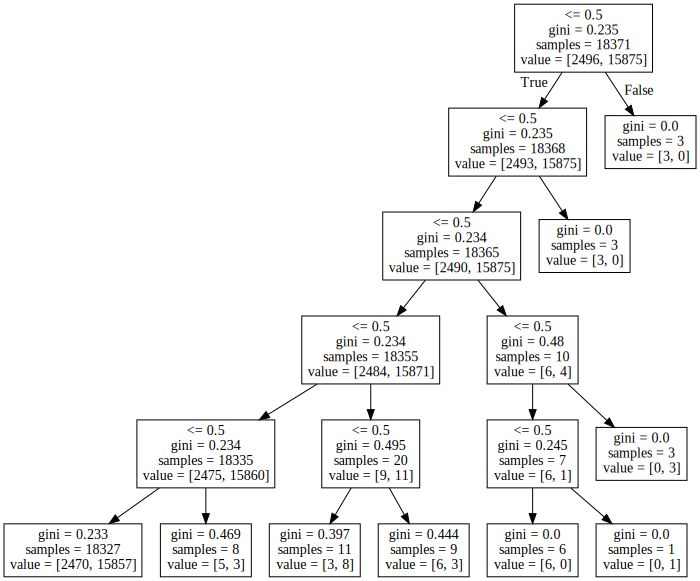

In [46]:
#第五步：画决策树

cwd=os.getcwd()
dot_data=tree.export_graphviz(dtc
                              ,out_file=None
                              ,feature_names=count_vec.get_feature_names())
graph=graphviz.Source(dot_data)
graph.format='svg'
graph.render(cwd+'/tree',view=True)
graph

### （二）情感分析

(1)导入评价情感词

In [47]:
#来自知网发布的情感分析用词语集

pos_comment=pd.read_csv('正面评价词语（中文）.txt',header=None,sep='\n',encoding='utf-8') 
neg_comment=pd.read_csv('负面评价词语（中文）.txt',header=None,sep='\n',encoding='utf-8')

pos_emotion=pd.read_csv('正面情感词语（中文）.txt',header=None,sep='\n',encoding='utf-8')
neg_emotion=pd.read_csv('负面情感词语（中文）.txt',header=None,sep='\n',encoding='utf-8')

In [48]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [49]:
pos=pd.concat([pos_comment,pos_emotion],axis=0)
pos.shape

neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape

(4576, 1)

(4389, 1)

(2)增加新词

In [50]:
c='点赞'
c in pos.values

d='歇菜'
d in neg.values

False

False

In [51]:
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['歇菜'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [52]:
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [53]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [54]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape

(8967, 2)

(3)合并到review_long_clean中

In [55]:
#表联接

data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')
review_mltype.shape

review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype.head()

(250102, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,酒店,n,1,1,0.0
1,1,适合,v,1,2,0.0
2,1,家庭,n,1,3,0.0
3,1,出行,v,1,4,0.0
4,2,升级,vn,1,1,0.0


(4)修正情感倾向，

如有多重否定，那么奇数否定是否定，偶数否定是肯定

看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

In [56]:
notdict=pd.read_csv('not.csv')
notdict.shape

notdict['freq']=[1]*len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [57]:
#准备一
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,酒店,n,1,1,0.0,0.0,0
1,1,适合,v,1,2,0.0,0.0,1
2,1,家庭,n,1,3,0.0,0.0,2
3,1,出行,v,1,4,0.0,0.0,3
4,2,升级,vn,1,1,0.0,0.0,4


In [58]:
# 准备二，只保留有情感值的行

only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype.head()

(6893, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,2,赞,v,1,5,1.0,1.0,8
1,5,好评,v,1,3,1.0,1.0,25
2,11,赞,v,0,14,1.0,1.0,67
3,15,高,a,0,2,-1.0,-1.0,89
4,18,高,a,1,3,-1.0,-1.0,114


In [59]:
i=4
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
112,18,住,v,1,1,0.0,0.0,112
113,18,性价比,n,1,2,0.0,0.0,113
114,18,高,a,1,3,-1.0,-1.0,114


In [60]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index=np.arange(0,review_i.shape[0])#重置索引后，索引值等价于index_word
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne==1:
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [61]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] #说明两列值一样

(250102, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


(5)计算每条评论的情感值

In [62]:
review_mltype.tail()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
250097,25225,位置,v,1,1,0.0,0.0,250097
250098,25225,好找,v,1,2,0.0,0.0,250098
250099,25225,停车,v,1,3,0.0,0.0,250099
250100,25225,酒店,n,1,4,0.0,0.0,250100
250101,25225,太,d,1,5,0.0,0.0,250101


In [63]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('./1_emotion_value',index=True,header=True)

,index_content,amend_weight
0,1,0.0
1,2,1.0
2,3,0.0
3,4,0.0
4,5,1.0


(6)查看情感分析效果

In [64]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value.head()

(22964, 2)

<ipython-input-64-2f057f38fab7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
<ipython-input-64-2f057f38fab7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'


(5193, 3)

,index_content,amend_weight,ml_type
1,2,1.0,pos
4,5,1.0,pos
10,11,1.0,pos
13,15,-1.0,neg
16,18,-1.0,neg


In [65]:
#每条评论的amend_weight总和等于零
#这个方法其实不好用，有一半以上的评论区分不出正、负情感。

# content_emotion_value0=emotion_value.copy()
# content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
# content_emotion_value0.head()

# raw_data.content[6]
# raw_data.content[7]
# raw_data.content[8]

In [66]:
#合并到大表中

content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype.head()

review_mltype.to_csv('./1_review_mltype',index=True,header=True)

(250102, 8)

(250102, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,酒店,n,1,1,0.0,0.0,NaN
1,1,适合,v,1,2,0.0,0.0,NaN
2,1,家庭,n,1,3,0.0,0.0,NaN
3,1,出行,v,1,4,0.0,0.0,NaN
4,2,升级,vn,1,1,0.0,0.0,pos


In [67]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True)
confusion_matrix

ml_type,neg,pos,All
content_type,,,
0,166,526,692
1,1092,3409,4501
All,1258,3935,5193


In [68]:
data=data_type[['content_type','ml_type']]
data=data.dropna(axis=0)
#print(classification_report(data['content_type'],data['ml_type']) )

(7)制作词云图

- 只看情感词

In [69]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

<Figure size 1080x504 with 0 Axes>

(-0.5, 655.5, 536.5, -0.5)

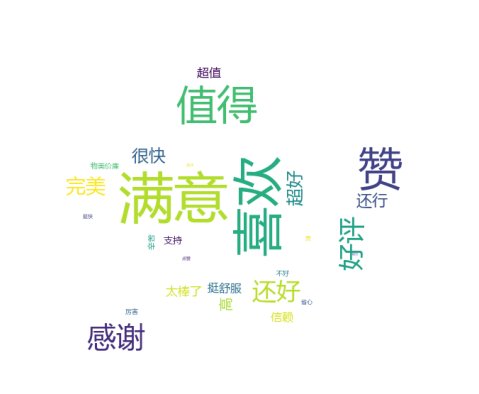

In [70]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1080x504 with 0 Axes>

(-0.5, 655.5, 536.5, -0.5)

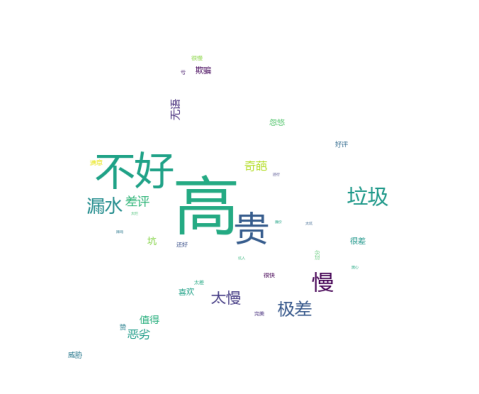

In [71]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 看所有词

<Figure size 1080x504 with 0 Axes>

(-0.5, 655.5, 536.5, -0.5)

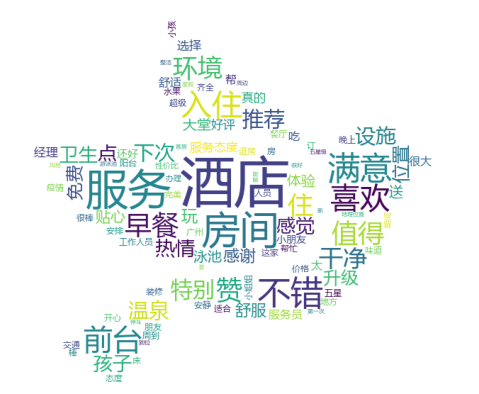

<Figure size 1080x504 with 0 Axes>

(-0.5, 655.5, 536.5, -0.5)

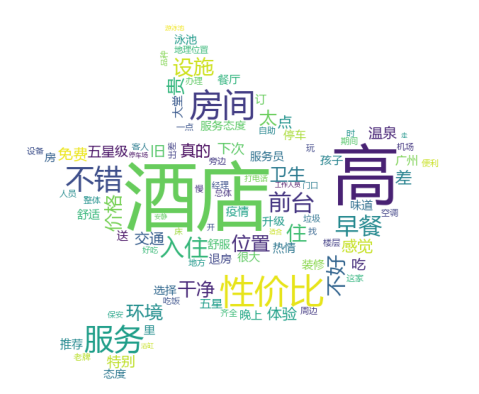

In [72]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

background_image=plt.imread('p1.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### （三）基于LDA模型的主题分析

优点：不需要人工调试，用相对少的迭代找到最优的主题结构。

（1）建立词典、语料库

In [73]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

In [74]:
#建立词典，去重

pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [75]:
print(pos_dict)

Dictionary(8887 unique tokens: ['升级', '房间', '延迟', '退房', '赞']...)


In [76]:
#建立语料库

pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] #shape=(n,(2,1))
neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

In [77]:
len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus  #元素是元组，元组（x,y),x是在词典中的位置，y是1表示存在。

74740

8887

74740

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(7, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(11, 1)],
 [(12, 1)],
 [(13, 1)],
 [(8, 1)],
 [(14, 1)],
 [(15, 1)],
 [(16, 1)],
 [(17, 1)],
 [(18, 1)],
 [(19, 1)],
 [(4, 1)],
 [(20, 1)],
 [(7, 1)],
 [(9, 1)],
 [(21, 1)],
 [(22, 1)],
 [(23, 1)],
 [(24, 1)],
 [(25, 1)],
 [(26, 1)],
 [(23, 1)],
 [(27, 1)],
 [(1, 1)],
 [(28, 1)],
 [(29, 1)],
 [(30, 1)],
 [(19, 1)],
 [(31, 1)],
 [(32, 1)],
 [(1, 1)],
 [(26, 1)],
 [(33, 1)],
 [(34, 1)],
 [(31, 1)],
 [(35, 1)],
 [(36, 1)],
 [(37, 1)],
 [(38, 1)],
 [(39, 1)],
 [(40, 1)],
 [(1, 1)],
 [(31, 1)],
 [(41, 1)],
 [(42, 1)],
 [(43, 1)],
 [(44, 1)],
 [(45, 1)],
 [(46, 1)],
 [(47, 1)],
 [(48, 1)],
 [(44, 1)],
 [(49, 1)],
 [(50, 1)],
 [(51, 1)],
 [(1, 1)],
 [(52, 1)],
 [(53, 1)],
 [(7, 1)],
 [(54, 1)],
 [(55, 1)],
 [(56, 1)],
 [(6, 1)],
 [(57, 1)],
 [(58, 1)],
 [(8, 1)],
 [(1, 1)],
 [(59, 1)],
 [(60, 1)],
 [(61, 1)],
 [(62, 1)],
 [(41, 1)],
 [(20, 1)],
 [(63, 1)],
 [(64, 1)],
 [

(2)主题数寻优


In [78]:
#构造主题数寻优函数

def cos(vector1,vector2):
    '''
    函数功能：余玄相似度函数
    '''
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [79]:
#主题数寻优
#这个函数可以重复调用，解决其他项目的问题

def LDA_k(x_corpus,x_dict):
    '''
    函数功能：
    '''
    #初始化平均余玄相似度
    mean_similarity=[]
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda=models.LdaModel(x_corpus,num_topics=i,id2word=x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term=lda.show_topics(num_words=50)
        
        #提取各主题词
        top_word=[] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word=sum(top_word,[]) #列车所有词
        unique_word=set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat=[] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w=top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
        y=len(p) # y=i*(i-1)
        top_similarity=[0]
        for w in np.arange(y):
            vector1=mat[p[w][0]]
            vector2=mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))

#        #两两组合，方法二
#        for x in range(i-1):
#            for y in range(x,i):
            
        #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

In [80]:
#计算主题平均余玄相似度

pos_k=LDA_k(pos_corpus,pos_dict)
neg_k=LDA_k(neg_corpus,neg_dict)

pos_k
neg_k

[1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0007142857142857143,
 0.0,
 0.008000000000000002]

[1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0007142857142857143,
 0.0,
 0.0017777777777777779]

Text(0.5, 1.0, '正面评论LDA主题数寻优')

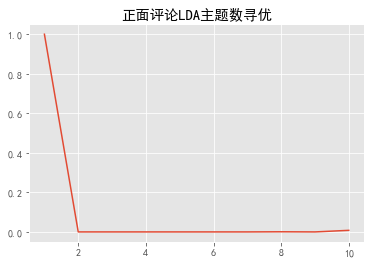

In [81]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

Text(0.5, 1.0, '负面评论LDA主题数寻优')

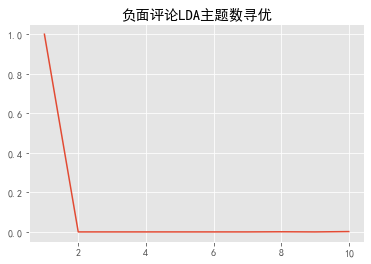

In [82]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [83]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)

pos_lda.print_topics(num_topics=10)
neg_lda.print_topics(num_topics=10)

[(0,
  '0.086*"酒店" + 0.021*"入住" + 0.020*"赞" + 0.019*"环境" + 0.013*"特别" + 0.012*"卫生" + 0.010*"点" + 0.010*"热情" + 0.009*"位置" + 0.008*"舒适"'),
 (1,
  '0.043*"服务" + 0.040*"房间" + 0.035*"不错" + 0.029*"满意" + 0.026*"前台" + 0.023*"早餐" + 0.021*"喜欢" + 0.019*"值得" + 0.016*"住" + 0.015*"干净"')]

[(0,
  '0.033*"房间" + 0.026*"服务" + 0.018*"入住" + 0.018*"不好" + 0.015*"早餐" + 0.013*"设施" + 0.010*"价格" + 0.010*"干净" + 0.008*"体验" + 0.008*"差"'),
 (1,
  '0.073*"酒店" + 0.051*"高" + 0.039*"性价比" + 0.027*"不错" + 0.018*"前台" + 0.014*"位置" + 0.012*"住" + 0.012*"太" + 0.012*"卫生" + 0.009*"环境"')]